# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st 

from sklearn.model_selection import train_test_split

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification

Установим случайное число

In [1]:
random_value = 2021

Отключим предупреждения

In [3]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

Считаем данные.

In [4]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Посмотрим содержимое.

In [8]:
display(data0.head())
display(data1.head())
display(data2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Проверим есть ли полные дубликаты и дубликаты по id для 0-го региона

In [9]:
data0[data0.duplicated()]

,id,f0,f1,f2,product


In [10]:
data0[data0.duplicated(subset = ['id'])]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


Проверим есть ли полные дубликаты и дубликаты по id для 1-го региона

In [11]:
data1[data1.duplicated()]

,id,f0,f1,f2,product


In [12]:
data1[data1.duplicated(subset = ['id'])]

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


Проверим есть ли полные дубликаты и дубликаты по id для 2-го региона

In [13]:
data2[data2.duplicated()]

,id,f0,f1,f2,product


In [14]:
data2[data2.duplicated(subset = ['id'])]

,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Поскольку полные дубликаты отсутствуют, а дубликатов по id очень малое количество. Принимаем решение от них не избавляться и оставить всё как есть.

Столбец id нам не пригодится. Можем от него избавиться. Напишем функцию и используем её на каждом датасете.

In [15]:
def drop_col(data, field):
    return data.drop([field], axis = 1)

In [16]:
data0 = drop_col(data0, 'id')
data1 = drop_col(data1, 'id')
data2 = drop_col(data2, 'id')

Посмотрим на матрицу корреляции для каждого датасета. Оформим её в отдельную функцию.

In [17]:
def data_corr(data):
    corr = data.corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot = True)

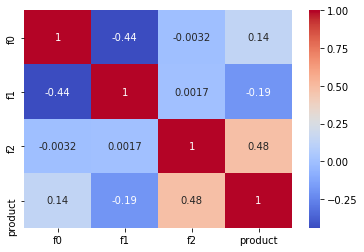

In [18]:
data_corr(data0)

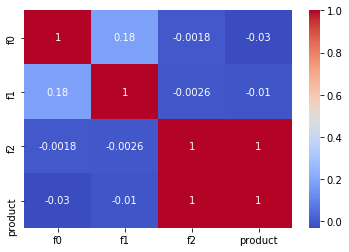

In [19]:
data_corr(data1)

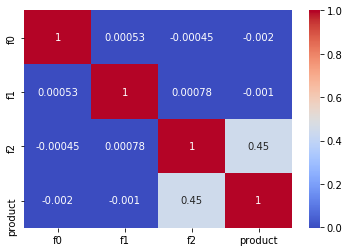

In [20]:
data_corr(data2)

Напишем функцию для определения обучающей и валидационной выборок из первоначального датасета

In [21]:
def super_split_data(data):
    # Получим обучающую и валидационную выборки 
    data_train, data_valid = train_test_split(data, test_size=0.25, random_state=random_value, shuffle = True)
    
    return data_train, data_valid

Определим функции которые будут выделять отдельно признаки и отдельно целевой признак.

In [22]:
def get_target(data, field):
    return data[field]

In [23]:
def get_features(data, field):
    return data.drop([field], axis = 1)

И функцию, возвращающую отдельно признаки и целевой признак.


In [24]:
def ftr_trgt_split(data, target_field):
    features_train = get_features(data, target_field)
    target_train = get_target(data, target_field)
    return features_train, target_train

###### Разделим датасет 0-го региона.

In [25]:
data0_train, data0_valid = super_split_data(data0)

Разобьем каждую из выборок на признаки и целевой признак

In [26]:
features0_train, target0_train = ftr_trgt_split(data0_train, 'product')
features0_valid, target0_valid = ftr_trgt_split(data0_valid, 'product')

###### Разделим датасет 1-го региона.

In [27]:
data1_train, data1_valid = super_split_data(data1)

features1_train, target1_train = ftr_trgt_split(data1_train, 'product')
features1_valid, target1_valid = ftr_trgt_split(data1_valid, 'product')

###### Разделим датасет 2-го региона.

In [28]:
data2_train, data2_valid = super_split_data(data2)

features2_train, target2_train = ftr_trgt_split(data2_train, 'product')
features2_valid, target2_valid = ftr_trgt_split(data2_valid, 'product')

Приведем все признаки к одному масштабу.  
Напишем функцию.

In [29]:
def super_scaler(data_train, data_valid):
    numeric = data_train.columns

    scaler = StandardScaler()
    scaler.fit(data_train[numeric])
    data_train[numeric] = scaler.transform(data_train[numeric])
    data_valid[numeric] = scaler.transform(data_valid[numeric])
    return data_train, data_valid

In [30]:
features1_valid.head(5)

,f0,f1,f2
23307,-10.857844,0.375746,4.994666
36679,-6.588782,-1.911753,2.006798
36626,-12.900191,-9.675777,5.002740
83753,5.058371,-6.845921,4.995702
52604,15.639849,-1.218381,4.000002


Приведем все признаки к единому масштабу для данных каждого региона.

In [31]:
features0_train, features0_valid = super_scaler(features0_train, features0_valid)

In [32]:
features1_train, features1_valid = super_scaler(features1_train, features1_valid)

In [33]:
features2_train, features2_valid = super_scaler(features2_train, features2_valid)

###### Вывод

Изучили содержимое таблиц. Убедились в отсутствии пропусков. Проверили данные на полные дубликаты и дубликаты по id. Поскольку полные дубликаты отсутствуют, а дубликатов по id очень малое количество - приняли решение от них не избавляться и оставить всё как есть. Столбец id при обучении моделей нам не пригодится – избавимся от него. Изучили матрицы корреляции для данных по каждому региону. Замечаем, что для 1-го региона признак f2 очень сильно коррелирует с целевым признаком. Разделили данные каждого региона на обучающую и валидационную выборки (в соотношении 75:25), а также на признаки и целевой признак. Привели признаки к единому масштабу для данных каждого региона.

## Обучение и проверка модели

Напишем функцию обучения модели линейной регрессии.

In [34]:
def lin_regress(features, target):
    reg = LinearRegression()
    reg.fit(features, target)
    return reg

Напишем функцию для обучения модели SGDRegressor

In [35]:
def regr_sgd(features, target):
    reg = SGDRegressor()
    reg.fit(features, target)
    return reg

Напишем функцию для обучения модели HuberRegressor

In [36]:
def regr_huber(features, target):
    reg = HuberRegressor()
    reg.fit(features, target)
    return reg

Напишем функцию предсказания на основе обученной модели.
Поскольку предсказания выводятся в массиве, привидем к Series и установим аналогичные с target индексы.  

Поскольку предсказания выводятся в массиве. Напишем функцию привидения к Series и установим аналогичные с target индексы.

In [37]:
def find_predictions(model, features_valid, indexes):
    predictions = model.predict(features_valid)
    
    np_array = np.array(predictions)
    new_predictions = pd.Series(np_array, index = indexes)
    
    return new_predictions

Напишем функции нахождения статистических параметров.

In [38]:
def find_mse(target, predicted):
    print("MSE =", mean_squared_error(target, predicted))

def find_rmse(target, predicted):
    print("RMSE =", mean_squared_error(target, predicted) ** 0.5)
    
def find_r2(target, predicted):
    print("R2 =", r2_score(target, predicted))

def find_mean(seria, label):
    print(label, seria.mean())

###### Проанализируем данные по 0-му региону

Обучим линейную модель на данных 0-го региона.

In [39]:
model_lin_reg_0 = lin_regress(features0_train, target0_train)

Найдем предсказания по валидационной выборке

In [40]:
predictions_0 = find_predictions(model_lin_reg_0, features0_valid, target0_valid.index)

Оценим параметры

In [41]:
find_mse(target0_valid, predictions_0)
find_rmse(target0_valid, predictions_0)
find_r2(target0_valid, predictions_0)
find_mean(target0_valid, 'Средний реальный запас сырья:')
find_mean(predictions_0, 'Средний предсказанный запас сырья:')

MSE = 1412.6244385381565
RMSE = 37.584896415158
R2 = 0.27416947215836573
Средний реальный запас сырья: 92.59154798340687
Средний предсказанный запас сырья: 92.67593566325512


Обучим модель SGDRegressor на данных 0-го региона.

In [42]:
model_sgd_reg_0 = regr_sgd(features0_train, target0_train)

Найдем предсказания по валидационной выборке

In [43]:
predictions_sgd_0 = find_predictions(model_sgd_reg_0, features0_valid, target0_valid.index)

Оценим параметры

In [44]:
find_mse(target0_valid, predictions_sgd_0)
find_rmse(target0_valid, predictions_sgd_0)
find_r2(target0_valid, predictions_sgd_0)
find_mean(target0_valid, 'Средний реальный запас сырья:')
find_mean(predictions_sgd_0, 'Средний предсказанный запас сырья:')

MSE = 1412.3813946228347
RMSE = 37.581663010341025
R2 = 0.27429435226700183
Средний реальный запас сырья: 92.59154798340687
Средний предсказанный запас сырья: 92.49233305226215


Обучим модель HuberRegressor на данных 0-го региона. Найдем предсказания и оценим параметры.

In [45]:
model_huber_reg_0 = regr_huber(features0_train, target0_train)

predictions_huber_0 = find_predictions(model_huber_reg_0, features0_valid, target0_valid.index)

find_mse(target0_valid, predictions_huber_0)
find_rmse(target0_valid, predictions_huber_0)
find_r2(target0_valid, predictions_huber_0)
find_mean(target0_valid, 'Средний реальный запас сырья:')
find_mean(predictions_huber_0, 'Средний предсказанный запас сырья:')

MSE = 1416.4856015113783
RMSE = 37.63622724864141
R2 = 0.27218554077329327
Средний реальный запас сырья: 92.59154798340687
Средний предсказанный запас сырья: 92.65135988723215


###### Проанализируем данные по 1-му региону

Обучим модель на данных 1-го региона.

In [46]:
model_lin_reg_1 = lin_regress(features1_train, target1_train)

Найдем предсказания по валидационной выборке

In [47]:
predictions_1 = find_predictions(model_lin_reg_1, features1_valid, target1_valid.index)

Оценим параметры

In [48]:
find_mse(target1_valid, predictions_1)
find_rmse(target1_valid, predictions_1)
find_r2(target1_valid, predictions_1)
find_mean(target1_valid, 'Средний реальный запас сырья:')
find_mean(predictions_1, 'Средний предсказанный запас сырья:')

MSE = 0.7927084870200093
RMSE = 0.8903417810144648
R2 = 0.999627404125662
Средний реальный запас сырья: 68.8294618013646
Средний предсказанный запас сырья: 68.83871774575076


Обучим модель SGDRegressor на данных 1-го региона. Найдем предсказания и оценим параметры.

In [49]:
model_sgd_reg_1 = regr_sgd(features1_train, target1_train)

predictions_sgd_1 = find_predictions(model_sgd_reg_1, features1_valid, target1_valid.index)

find_mse(target1_valid, predictions_sgd_1)
find_rmse(target1_valid, predictions_sgd_1)
find_r2(target1_valid, predictions_sgd_1)
find_mean(target1_valid, 'Средний реальный запас сырья:')
find_mean(predictions_sgd_1, 'Средний предсказанный запас сырья:')

MSE = 0.7926381355705518
RMSE = 0.8903022720236942
R2 = 0.9996274371928743
Средний реальный запас сырья: 68.8294618013646
Средний предсказанный запас сырья: 68.83186914156295


Обучим модель HuberRegressor на данных 1-го региона. Найдем предсказания и оценим параметры.

In [50]:
model_huber_reg_1 = regr_huber(features1_train, target1_train)

predictions_huber_1 = find_predictions(model_huber_reg_1, features1_valid, target1_valid.index)

find_mse(target1_valid, predictions_huber_1)
find_rmse(target1_valid, predictions_huber_1)
find_r2(target1_valid, predictions_huber_1)
find_mean(target1_valid, 'Средний реальный запас сырья:')
find_mean(predictions_huber_1, 'Средний предсказанный запас сырья:')

MSE = 0.7936844342800511
RMSE = 0.8908896869310201
R2 = 0.9996269454022743
Средний реальный запас сырья: 68.8294618013646
Средний предсказанный запас сырья: 68.83889099625095


###### Проанализируем данные по 2-му региону

Обучим модель на данных 2-го региона.

In [51]:
model_lin_reg_2 = lin_regress(features2_train, target2_train)

Найдем предсказания по валидационной выборке

In [52]:
predictions_2 = find_predictions(model_lin_reg_2, features2_valid, target2_valid.index)

Оценим параметры

In [53]:
find_mse(target2_valid, predictions_2)
find_rmse(target2_valid, predictions_2)
find_r2(target2_valid, predictions_2)
find_mean(target2_valid, 'Средний реальный запас сырья:')
find_mean(predictions_2, 'Средний предсказанный запас сырья:')

MSE = 1599.6284398664257
RMSE = 39.99535522865656
R2 = 0.20018490294080582
Средний реальный запас сырья: 94.87823945324702
Средний предсказанный запас сырья: 94.9891117869199


Обучим модель SGDRegressor на данных 2-го региона. Найдем предсказания и оценим параметры.

In [54]:
model_sgd_reg_2 = regr_sgd(features2_train, target2_train)

predictions_sgd_2 = find_predictions(model_sgd_reg_2, features2_valid, target1_valid.index)

find_mse(target2_valid, predictions_sgd_2)
find_rmse(target2_valid, predictions_sgd_2)
find_r2(target2_valid, predictions_sgd_2)
find_mean(target2_valid, 'Средний реальный запас сырья:')
find_mean(predictions_sgd_2, 'Средний предсказанный запас сырья:')

MSE = 1600.5597840177718
RMSE = 40.006996688301555
R2 = 0.19971923035444783
Средний реальный запас сырья: 94.87823945324702
Средний предсказанный запас сырья: 94.41819607621062


Обучим модель HuberRegressor на данных 1-го региона. Найдем предсказания и оценим параметры.

In [55]:
model_huber_reg_2 = regr_huber(features2_train, target2_train)

predictions_huber_2 = find_predictions(model_huber_reg_2, features2_valid, target2_valid.index)

find_mse(target2_valid, predictions_huber_2)
find_rmse(target2_valid, predictions_huber_2)
find_r2(target2_valid, predictions_huber_2)
find_mean(target2_valid, 'Средний реальный запас сырья:')
find_mean(predictions_huber_2, 'Средний предсказанный запас сырья:')

MSE = 1602.4021764522558
RMSE = 40.03001594369225
R2 = 0.19879803312696476
Средний реальный запас сырья: 94.87823945324702
Средний предсказанный запас сырья: 94.89053391820023


In [56]:
def get_stat():
    df = pd.DataFrame(columns=['Модель', 'MSE', 'RMSE', 'R2', 'Средний реальный запас сырья', 'Средний предсказанный запас сырья'])
    return df

def add_row(df, model_name, target, predicted):
    df = df.set_value(len(df), 'Модель', model_name)
    df = df.set_value(len(df) - 1, 'MSE', mean_squared_error(target, predicted))
    df = df.set_value(len(df) - 1, 'RMSE', mean_squared_error(target, predicted)  ** 0.5)
    df = df.set_value(len(df) - 1, 'R2', r2_score(target, predicted))
    df = df.set_value(len(df) - 1, 'Средний реальный запас сырья', target.mean())
    df = df.set_value(len(df) - 1, 'Средний предсказанный запас сырья', predicted.mean())
    return df

Заполним статистику по 0-му региону.

In [57]:
stat_0_reg = get_stat()
stat_0_reg = add_row(stat_0_reg,
            'linear_regression',
             target0_valid,
             predictions_0
            )

stat_0_reg = add_row(stat_0_reg,
            'SGDRegressor',
             target0_valid,
             predictions_sgd_0
            )

stat_0_reg = add_row(stat_0_reg,
            'HuberRegressor',
             target0_valid,
             predictions_huber_0
            )
display(stat_0_reg)

,Модель,MSE,RMSE,R2,Средний реальный запас сырья,Средний предсказанный запас сырья
0,linear_regression,1412.62,37.5849,0.274169,92.5915,92.6759
1,SGDRegressor,1412.38,37.5817,0.274294,92.5915,92.4923
2,HuberRegressor,1416.49,37.6362,0.272186,92.5915,92.6514


Заполним статистику по 1-му региону.

In [58]:
stat_1_reg = get_stat()
stat_1_reg = add_row(stat_1_reg,
            'linear_regression',
             target1_valid,
             predictions_1
            )

stat_1_reg = add_row(stat_1_reg,
            'SGDRegressor',
             target1_valid,
             predictions_sgd_1
            )

stat_1_reg = add_row(stat_1_reg,
            'HuberRegressor',
             target1_valid,
             predictions_huber_1
            )
display(stat_1_reg)

,Модель,MSE,RMSE,R2,Средний реальный запас сырья,Средний предсказанный запас сырья
0,linear_regression,0.792708,0.890342,0.999627,68.8295,68.8387
1,SGDRegressor,0.792638,0.890302,0.999627,68.8295,68.8319
2,HuberRegressor,0.793684,0.89089,0.999627,68.8295,68.8389


Заполним статистику по 2-му региону.

In [59]:
stat_2_reg = get_stat()
stat_2_reg = add_row(stat_2_reg,
            'linear_regression',
             target0_valid,
             predictions_0
            )

stat_2_reg = add_row(stat_2_reg,
            'SGDRegressor',
             target0_valid,
             predictions_sgd_0
            )

stat_2_reg = add_row(stat_2_reg,
            'HuberRegressor',
             target0_valid,
             predictions_huber_0
            )
display(stat_2_reg)

,Модель,MSE,RMSE,R2,Средний реальный запас сырья,Средний предсказанный запас сырья
0,linear_regression,1412.62,37.5849,0.274169,92.5915,92.6759
1,SGDRegressor,1412.38,37.5817,0.274294,92.5915,92.4923
2,HuberRegressor,1416.49,37.6362,0.272186,92.5915,92.6514


###### Вывод: 

Написали функции для обучения модели линейной регрессии, модели SGDRegressor, модели HuberRegressor. Написали функцию предсказания на основе обученной модели. Поскольку предсказания выводятся в массиве, привели к Series и установили аналогичные с target индексы. Написали функции нахождения результатов успешности модели – MSE, RMSE, R2. А также - Средний реальный запас сырья и Средний предсказанный запас сырья.
Получили следующие результаты:

###### Данные по 0-му региону
Представлены в таблице ниже:

In [60]:
display(stat_0_reg)

,Модель,MSE,RMSE,R2,Средний реальный запас сырья,Средний предсказанный запас сырья
0,linear_regression,1412.62,37.5849,0.274169,92.5915,92.6759
1,SGDRegressor,1412.38,37.5817,0.274294,92.5915,92.4923
2,HuberRegressor,1416.49,37.6362,0.272186,92.5915,92.6514


###### Данные по 1-му региону
Представлены в таблице ниже:

In [61]:
display(stat_1_reg)

,Модель,MSE,RMSE,R2,Средний реальный запас сырья,Средний предсказанный запас сырья
0,linear_regression,0.792708,0.890342,0.999627,68.8295,68.8387
1,SGDRegressor,0.792638,0.890302,0.999627,68.8295,68.8319
2,HuberRegressor,0.793684,0.89089,0.999627,68.8295,68.8389


###### Проанализируем данные по 2-му региону
Представлены в таблице ниже:

In [62]:
display(stat_2_reg)

,Модель,MSE,RMSE,R2,Средний реальный запас сырья,Средний предсказанный запас сырья
0,linear_regression,1412.62,37.5849,0.274169,92.5915,92.6759
1,SGDRegressor,1412.38,37.5817,0.274294,92.5915,92.4923
2,HuberRegressor,1416.49,37.6362,0.272186,92.5915,92.6514


###### Обобщая:
Линейная модель получилась самой успешной. Показатель R2 – самый высокий и, соответственно, метрики MSE, RMSE – самые низкие.   
При этом значения метрики R2, > 0, демонстрируют то, что модель полезна и прогнозирует лучше, чем условные случайные предсказания.  
На данных первого региона видим почти 100% попадание (R2 стремится к 1). Это произошло за счёт, фактически, прямой корреляции одного из признаков с целевым, замеченной нами ранее.  

## Подготовка к расчёту прибыли

Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины.

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [63]:
BUDGET_OF_REGION = 10000000000
PRICE = 450000
OIL_WELL = 200

In [64]:
print('Объём сырья для безубыточной разработки новой скважины: ', BUDGET_OF_REGION / PRICE / OIL_WELL)

Объём сырья для безубыточной разработки новой скважины:  111.11111111111111


Сравним полученный объём сырья со средним запасом в каждом регионе. 

In [65]:
print('Средний объем запасов скважины в 0-м регионе: ', data0['product'].mean())
print('Средний объем запасов скважины в 1-м регионе: ', data1['product'].mean())
print('Средний объем запасов скважины в 2-м регионе: ', data2['product'].mean())

Средний объем запасов скважины в 0-м регионе:  92.50000000000001
Средний объем запасов скважины в 1-м регионе:  68.82500000000002
Средний объем запасов скважины в 2-м регионе:  95.00000000000004


###### Вывод: 

Объём сырья для безубыточной разработки новой скважины равен 111.11, но при этом объем запасов среднестатистической скважины в регионах значительно меньше этого значения: 92.5, 68.83, 95.

При этом особенно выделяется 1-ый регион, средние запасы которого меньше необходимых 111,11 в более чем 1,5 раза. Но, при этом, наша модель очень хорошо прогнозирует запасы скважин именно в этом регионе.

## Расчёт прибыли и рисков 

Напишем функцию подсчета прибыли для выбранных скважин.

In [66]:
def revenue(target, predictions, cost, count):
    probs_sorted = predictions.sort_values(ascending=False)
    deposits = target[probs_sorted.index][:count]
    return cost * deposits.sum() - BUDGET_OF_REGION

Напишем функцию, в которой сгенерируем 1000 выборок, чтобы найти распределение прибыли 

In [67]:
def super_bootsrtap(target, predictions):
    state = np.random.RandomState(12345)

    values = []
    for i in range(1000):
        some_target = target.sample(replace = True, random_state = state, n = 500)
        some_predictions = predictions[some_target.index]

        values.append(revenue(some_target, some_predictions, PRICE, 200))

    values = pd.Series(values)
    return values 

Напишем функции вычисляющие среднюю выручку, 95%-й доверительный интервал и риск убытков.

In [68]:
def mean_revenue(values):
    print("Средняя выручка:", values.mean())
    
def dov_interval_95(values):
    print("95%-й Доверительный интервал:", values.quantile(0.025), '-', values.quantile(0.975))
    
def risk_of_loss(values):
    print("Риск убытков:", st.percentileofscore(values, 0), '%')

Найдем распределение возможной прибыли для каждого региона.

In [69]:
raspred_0 = super_bootsrtap(target0_valid, predictions_0)
raspred_1 = super_bootsrtap(target1_valid, predictions_1)
raspred_2 = super_bootsrtap(target2_valid, predictions_2)

Найдем статистичекие характеристики для распределения 0-го региона.

In [70]:
mean_revenue(raspred_0)
dov_interval_95(raspred_0)
risk_of_loss(raspred_0)

Средняя выручка: 457113928.16599864
95%-й Доверительный интервал: -70724706.13525699 - 1000293734.26832
Риск убытков: 5.0 %


Найдем статистичекие характеристики для распределения 1-го региона.

In [71]:
mean_revenue(raspred_1)
dov_interval_95(raspred_1)
risk_of_loss(raspred_1)

Средняя выручка: 522977226.6420639
95%-й Доверительный интервал: 88935781.55294026 - 963644260.1581268
Риск убытков: 0.4 %


Найдем статистичекие характеристики для распределения 2-го региона.

In [72]:
mean_revenue(raspred_2)
dov_interval_95(raspred_2)
risk_of_loss(raspred_2)

Средняя выручка: 363224735.8548959
95%-й Доверительный интервал: -192431772.25365472 - 859125011.8797085
Риск убытков: 10.4 %


In [73]:
def get_results():
    df = pd.DataFrame(columns=['Регион', 'Средняя прибыль', '95%-й Доверительный интервал', 'Риск убытков'])
    return df

def add_result(df, region_name, raspred):
    df = df.set_value(len(df), 'Регион', region_name)
    df = df.set_value(len(df) - 1, 'Средняя прибыль', round(raspred.mean()))
    df = df.set_value(len(df) - 1, '95%-й Доверительный интервал', str(round(raspred.quantile(0.025), 0)) + '-' + str(round(raspred.quantile(0.975))))
    df = df.set_value(len(df) - 1, 'Риск убытков', str(st.percentileofscore(raspred, 0)) + ' %')
    return df

In [74]:
results = get_results()
add_result(results, '0-й регион', raspred_0)
add_result(results, '1-й регион', raspred_1)
add_result(results, '2-й регион', raspred_2)
display(results)

,Регион,Средняя прибыль,95%-й Доверительный интервал,Риск убытков
0,0-й регион,457113928,-70724706.0-1000293734,5.0 %
1,1-й регион,522977227,88935782.0-963644260,0.4 %
2,2-й регион,363224736,-192431772.0-859125012,10.4 %


###### Вывод
Написали функцию подсчета прибыли для выбранных скважин, функцию, в которой сгенерируем 1000 выборок, чтобы найти распределение прибыли. И функции, вычисляющие среднюю выручку, 95%-й доверительный интервал и риск убытков.
Найдем распределение возможной прибыли для каждого региона по предсказаниям модели линейной регрессии.
И получили следующие результаты:

In [75]:
display(results)

,Регион,Средняя прибыль,95%-й Доверительный интервал,Риск убытков
0,0-й регион,457113928,-70724706.0-1000293734,5.0 %
1,1-й регион,522977227,88935782.0-963644260,0.4 %
2,2-й регион,363224736,-192431772.0-859125012,10.4 %


###### Обобщая. 
Можно сделать следующий вывод. По предварительным оценкам 1-й регион никак не подходил под выбор для разработки скважин. Средние запасы региона (68.8) гораздо меньше чем остальных регионов (92-95) и рассчитанного запаса для безубыточной разработки месторождения (111.11). Но, благодаря качественно прогнозирующей модели, самые оптимистичные прогнозы касаются именно 1-го региона – риск убытков всего 0.4%. И именно этот регион и предлагается для разработки на основании проведенного исследования.

## Вывод
###### Загрузка и подготовка данных

Изучили содержимое таблиц. Убедились в отсутствии пропусков. Проверили данные на полные дубликаты и дубликаты по id. Поскольку полные дубликаты отсутствуют, а дубликатов по id очень малое количество - приняли решение от них не избавляться и оставить всё как есть. Столбец id при обучении моделей нам не пригодится – избавимся от него. Изучили матрицы корреляции для данных по каждому региону. Замечаем, что для 1-го региона признак f2 очень сильно коррелирует с целевым признаком. Разделили данные каждого региона на обучающую и валидационную выборки (в соотношении 75:25), а также на признаки и целевой признак. Привели признаки к единому масштабу для данных каждого региона.

###### Обучение и проверка модели

Написали функции для обучения модели линейной регрессии, модели SGDRegressor, модели HuberRegressor. Написали функцию предсказания на основе обученной модели. Поскольку предсказания выводятся в массиве, привели к Series и установили аналогичные с target индексы. Написали функции нахождения результатов успешности модели – MSE, RMSE, R2. А также - Средний реальный запас сырья и Средний предсказанный запас сырья. Получили следующие результаты:

###### Данные по 0-му региону

In [76]:
display(stat_0_reg)

,Модель,MSE,RMSE,R2,Средний реальный запас сырья,Средний предсказанный запас сырья
0,linear_regression,1412.62,37.5849,0.274169,92.5915,92.6759
1,SGDRegressor,1412.38,37.5817,0.274294,92.5915,92.4923
2,HuberRegressor,1416.49,37.6362,0.272186,92.5915,92.6514


###### Данные по 1-му региону

In [77]:
display(stat_1_reg)

,Модель,MSE,RMSE,R2,Средний реальный запас сырья,Средний предсказанный запас сырья
0,linear_regression,0.792708,0.890342,0.999627,68.8295,68.8387
1,SGDRegressor,0.792638,0.890302,0.999627,68.8295,68.8319
2,HuberRegressor,0.793684,0.89089,0.999627,68.8295,68.8389


###### Данные по 2-му региону

In [78]:
display(stat_2_reg)

,Модель,MSE,RMSE,R2,Средний реальный запас сырья,Средний предсказанный запас сырья
0,linear_regression,1412.62,37.5849,0.274169,92.5915,92.6759
1,SGDRegressor,1412.38,37.5817,0.274294,92.5915,92.4923
2,HuberRegressor,1416.49,37.6362,0.272186,92.5915,92.6514


Линейная модель получилась самой успешной. Показатель R2 – самый высокий и, соответственно, метрики MSE, RMSE – самые низкие.
При этом значения метрики R2, > 0, демонстрируют то, что модель полезна и прогнозирует лучше, чем условные случайные предсказания.
На данных первого региона видим почти 100% попадание (R2 стремится к 1). Это произошло за счёт, фактически, прямой корреляции одного из признаков с целевым, замеченной нами ранее. 

###### Подготовка к расчёту прибыли

Объём сырья для безубыточной разработки новой скважины равен 111.11, но при этом объем запасов среднестатистической скважины в регионах значительно меньше этого значения: 92.5, 68.83, 95.

При этом особенно выделяется 1-ый регион, средние запасы которого меньше необходимых 111,11 в более чем 1,5 раза. Но, при этом, наша модель очень хорошо прогнозирует запасы скважин именно в этом регионе.

######  Расчёт прибыли и рисков

Написали функцию подсчета прибыли для выбранных скважин, функцию, в которой сгенерируем 1000 выборок, чтобы найти распределение прибыли. И функции, вычисляющие среднюю выручку, 95%-й доверительный интервал и риск убытков. Найдем распределение возможной прибыли для каждого региона по предсказаниям модели линейной регрессии. И получили следующие результаты:

In [79]:
display(results)

,Регион,Средняя прибыль,95%-й Доверительный интервал,Риск убытков
0,0-й регион,457113928,-70724706.0-1000293734,5.0 %
1,1-й регион,522977227,88935782.0-963644260,0.4 %
2,2-й регион,363224736,-192431772.0-859125012,10.4 %


###### Обобщая. 
Можно сделать следующий вывод. По предварительным оценкам 1-й регион никак не подходил под выбор для разработки скважин. Средние запасы региона (68.8) гораздо меньше чем остальных регионов (92-95) и рассчитанного запаса для безубыточной разработки месторождения (111.11). Но, благодаря качественно прогнозирующей модели, самые оптимистичные прогнозы касаются именно 1-го региона – риск убытков всего 0.4%. И именно этот регион и предлагается для разработки на основании проведенного исследования.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован